# Example 4: how to use random retrieval to plot distributions

In [1]:
import sys
from sgqlc.operation import Operation
from pdp_schema import pdp_schema as schema
from pdp_graphql_client_python import client

## 1. Set the API endpoint
set endpoint to old PDP (FARO) schema on INT

In [2]:
%set_env PDP_API=https://graphql-api.pdp.int.srgssr.ch/graphql

env: PDP_API=https://graphql-api.pdp.int.srgssr.ch/graphql


In [3]:
# fetch environment variable with PDP endpoint API address
! echo "${PDP_API}"

https://graphql-api.pdp.int.srgssr.ch/graphql


## 2. Show available queries

In [4]:
schema.Query

type Query {
  faroProgramPage(first: Int!, after: String): FaroProgramPage!
  faroPrograms(ids: [String!]!): [FaroProgram]!
  randomFaroPrograms: [FaroProgram!]!
  faroItemPage(first: Int!, after: String): FaroItemPage!
  faroItems(ids: [String!]!): [FaroItem]!
  faroItemsByPlayUrn(urns: [String!]!): [FaroItem]!
  faroItemsByPlayUrnGraphDb(urns: [String!]!): [FaroItem]!
  randomFaroItems: [FaroItem!]!
}

## 3. Configure the query operation

In [5]:
op = Operation(schema.Query)

In [6]:
faro = op.random_faro_items()

In [7]:
# return the current query
op

query {
  randomFaroItems {
    id
    programId
    itemNr
    rights
    isPoisonous
    playMedias {
      id
      title
      urn
      description
    }
    mediaUrns
    playLinks
    descriptorPaths
    program {
      id
      bu
      mediaType
      episodeIds
      sTit
      sDatStart
      sGef
      pTit
      department
      workgroup
      seriesNr
    }
    bTit
    recordingDate
    ingestDate
    prodTypes
    producer
    licenseHolder
    abs
    fdes
    sportDoc {
      season
      sportEventPaths
      sportPaths
    }
    webCmsIds
  }
}

## 4. Select fields of interest

In [8]:
faro.id()
faro.b_tit()
faro.producer()
faro.program.s_dat_start()
faro.sport_doc();

In [9]:
op

query {
  randomFaroItems {
    id
    bTit
    producer
    program {
      sDatStart
    }
    sportDoc {
      season
      sportEventPaths
      sportPaths
    }
  }
}

## 5. Retrieve the data

In [10]:
# constants
page_requests = 100

In [11]:
# init results
results = []

In [12]:
# download data
from tqdm.notebook import tnrange
for i in tnrange(page_requests, desc="Downloading data"):
    # query page
    data = client.run_query(op)
    
    # add results
    results += (op + data).random_faro_items

In [13]:
print(f'INFO - Retrieved {len(results):,} FaroItems')

INFO - Retrieved 1,000 FaroItems


In [14]:
results[0]

FaroItem(id='9c89171d-d913-48af-9a75-8ffbc76aac15', b_tit='Razzia Kinder-Pornografie', producer='SF', program=FaroProgram(s_dat_start='2007-05-08'), sport_doc=FaroSportDoc(season=None, sport_event_paths=[], sport_paths=[]))

## 6. Plot the year distribution of first display

In [15]:
results[0].program.s_dat_start

'2007-05-08'

In [16]:
from collections import Counter
from datetime import date

# count year occurrences
c = Counter(date.fromisoformat(x.program.s_dat_start).year 
            for x in results if x.program.s_dat_start)

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

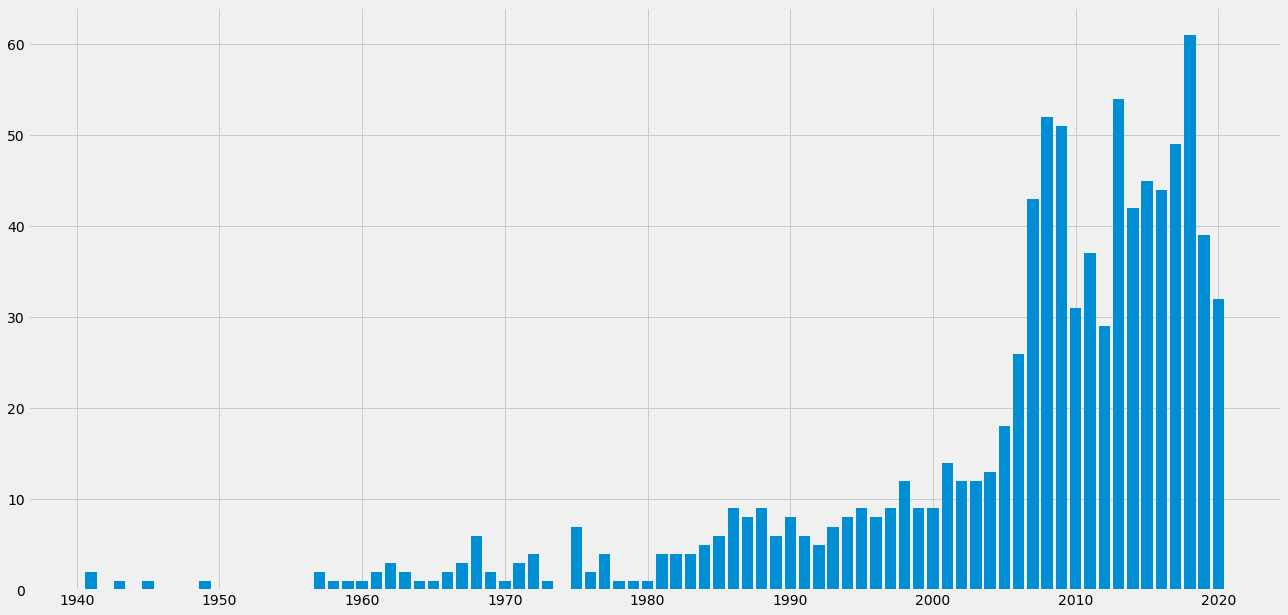

In [18]:
with plt.style.context('fivethirtyeight'):
    plt.bar(c.keys(), c.values())

## 7. Load data into a `pandas` dataframe

In [19]:
import pandas as pd

In [20]:
results[0].__fields_cache__

OrderedDict([('id', id: String!),
             ('b_tit', bTit: String),
             ('producer', producer: String),
             ('program', program: FaroProgram),
             ('sport_doc', sportDoc: FaroSportDoc!)])

In [21]:
df = pd.DataFrame([x.__json_data__ for x in results])

In [22]:
df

,program,bTit,sportDoc,id,producer
0,{'sDatStart': '2007-05-08'},Razzia Kinder-Pornografie,"{'season': None, 'sportEventPaths': [], 'sport...",9c89171d-d913-48af-9a75-8ffbc76aac15,SF
1,{'sDatStart': '2008-04-08'},Lohn-Dumping auf Westside-Baustelle,"{'season': None, 'sportEventPaths': [], 'sport...",9c8946bc-0a17-4b8e-b95a-0c73a545238d,SF
2,{'sDatStart': None},OS Sydney Leichtathletik,"{'season': None, 'sportEventPaths': ['¦int¦Oly...",9c894778-5cf0-461f-81f7-bca92ab4a200,SOBO
3,{'sDatStart': '2014-09-01'},SRF 1 01.09.2014 03 - 04 Uhr,"{'season': None, 'sportEventPaths': [], 'sport...",9c894846-e651-42af-9838-a36671099fb5,None
4,{'sDatStart': '1992-12-23'},Guido Baumann,"{'season': None, 'sportEventPaths': [], 'sport...",9c89509b-1194-48be-8a00-1bb56e1ce0b0,DRS
...,...,...,...,...,...
995,{'sDatStart': '2018-07-13'},Regionaljournal AG\/SO 13.07.2018 12:00 Uhr,"{'season': None, 'sportEventPaths': [], 'sport...",b5eefb73-59ac-4155-b914-11bbf3830cd6,None
996,{'sDatStart': None},Italien: PCI-Kongress,"{'season': None, 'sportEventPaths': [], 'sport...",b5eeff9d-54e8-4f42-9304-4c16dad12b00,EVN/RAI
997,{'sDatStart': '2016-06-22'},SRF 2 Kultur 22.06.2016 03 - 04 Uhr,"{'season': None, 'sportEventPaths': [], 'sport...",b5ef16ff-abe1-4368-b01e-682945e03bb4,None
998,{'sDatStart': '2009-05-18'},Regionaljournal AG\/SO 18.05.2009 08:30 Uhr,"{'season': None, 'sportEventPaths': [], 'sport...",b5ef1898-76af-47fd-9fe1-24f8a25b6d49,None


## 8. Simple plotting with `pandas`

In [23]:
df.producer.describe()

count     467
unique     80
top       SRF
freq      141
Name: producer, dtype: object

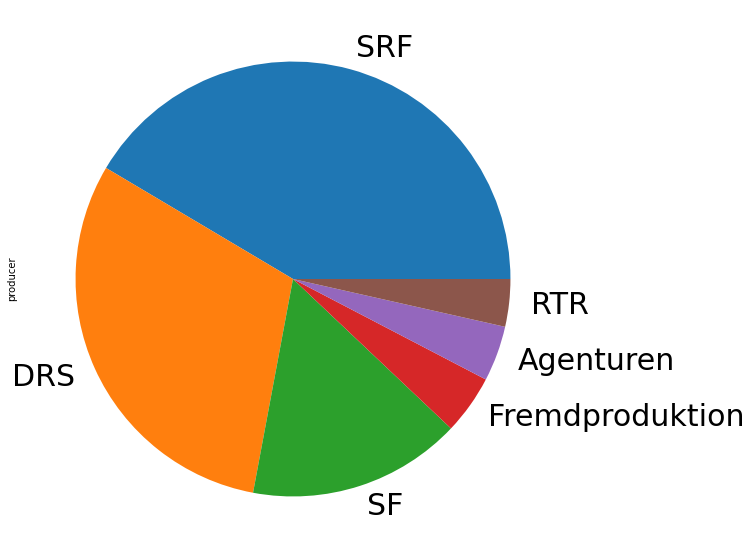

In [24]:
(df
 .groupby('producer')
 .filter(lambda x: len(x) > 10)
 .producer
 .value_counts()
 .plot
 .pie(fontsize=30));

## 9. Analysis of nested entries

In [25]:
pd.json_normalize(df.sportDoc).dropna().head()

,season,sportEventPaths,sportPaths
44,2016,[¦int¦Fedcup¦Fedcup Halbfinal¦],[¦Tennis¦]
56,2015,[],[¦Leichtathletik¦Hürdenlauf¦Hürden 100m¦]
58,2008-2009,[¦nat¦Schweizermeisterschaft¦],[¦Fussball¦]
66,2016,[¦int¦Paralympics¦],"[¦Behindertensport¦, ¦Leichtathletik¦]"
81,2013,[¦int¦Grand Slam Turnier¦Wimbledon (Rasen)¦Wim...,[¦Tennis¦]


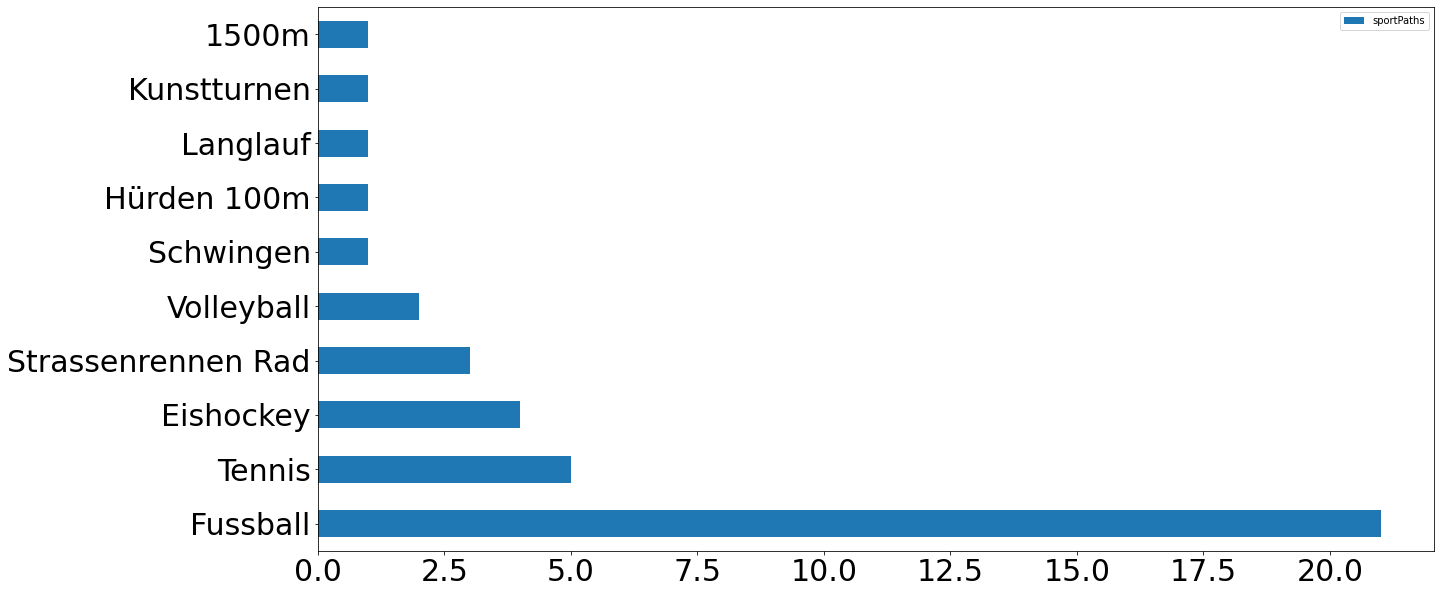

In [26]:
(pd
 .json_normalize(df.sportDoc)                # normalize sport doc entries
 .dropna()                                   # remove empty entries
 .sportPaths.explode()                       # explode array
 .str.split('¦').str[-2]                     # split by symbol and select 2nd to last
 .value_counts()                             # count occurrences
 .to_frame()                                 # transform to data frame
 .sort_values('sportPaths', ascending=False) # sort by occurrence
 .head(10)                                   # pick top 10
 .plot.barh(y='sportPaths', fontsize=30));   # plot as a horizontal bar chart